In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from pydicom import dcmread
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils import data

import torch.nn.functional as F
from torchvision.utils import make_grid, save_image

from matplotlib import rcParams

import matplotlib.patches as patches
from math import ceil

In [2]:
DATA_FOLDER = 'rsna-pneumonia-detection-challenge/'
random_seed = 42

np.random.seed(random_seed)
torch.manual_seed(random_seed);

# Loading the datasets

In [3]:
# Importing the datasets
label_data = pd.read_csv(DATA_FOLDER + 'stage_2_train_labels.csv')
class_info = pd.read_csv(DATA_FOLDER + 'stage_2_detailed_class_info.csv').drop_duplicates()
label_data.shape

(30227, 6)

In [4]:
# Merge the two datasets
label_data = label_data.merge(class_info, on='patientId')
label_data.shape

(30227, 7)

In [5]:
label_data.head()

,patientId,x,y,width,height,Target,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity


# Loading the images

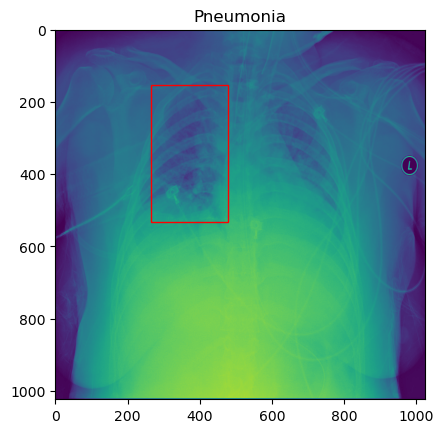

In [6]:
idx = 4

train_images = DATA_FOLDER + 'stage_2_train_images/'
image_name = label_data['patientId'][idx] + '.dcm'

ds = dcmread(train_images + image_name)
box = [label_data['x'][idx], label_data['y'][idx], label_data['width'][idx], label_data['height'][idx]]
rect = patches.Rectangle((box[0], box[1]), box[2], box[3], linewidth=1, edgecolor='r', facecolor='none')
fig, ax = plt.subplots(1)
ax.imshow(ds.pixel_array)
ax.add_patch(rect)
plt.title('Pneumonia' if label_data['Target'][idx] == 1 else 'No Pneumonia')
plt.show()

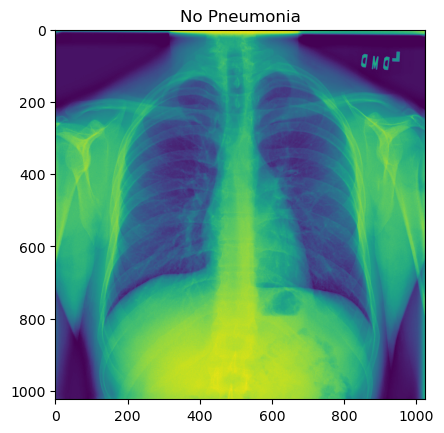

In [7]:
idx = 3

train_images = DATA_FOLDER + 'stage_2_train_images/'
image_name = label_data['patientId'][idx] + '.dcm'

ds = dcmread(train_images + image_name)
box = [label_data['x'][idx], label_data['y'][idx], label_data['width'][idx], label_data['height'][idx]]
rect = patches.Rectangle((box[0], box[1]), box[2], box[3], linewidth=1, edgecolor='r', facecolor='none')
fig, ax = plt.subplots(1)
ax.imshow(ds.pixel_array)
ax.add_patch(rect)
plt.title('Pneumonia' if label_data['Target'][idx] == 1 else 'No Pneumonia')
plt.show()

# Main pipeline

In [8]:
columns = ['patientId', 'Target']
all_data = label_data

label_data = label_data.filter(columns)
label_data.head(5)

,patientId,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,0
4,00436515-870c-4b36-a041-de91049b9ab4,1


In [9]:
all_data.shape

(30227, 7)

## Splitting the data

In [10]:
train_labels, test_labels = train_test_split(label_data.values, test_size=0.2, random_state=random_seed)
train_labels, val_labels = train_test_split(train_labels, test_size=0.25, random_state=random_seed)
print(train_labels.shape)
print(val_labels.shape)
print(test_labels.shape)

(18135, 2)
(6046, 2)
(6046, 2)


In [11]:
train_f = DATA_FOLDER + 'stage_2_train_images/'
test_f = DATA_FOLDER + 'stage_2_test_images/'

train_paths = [os.path.join(train_f, image[0]) for image in train_labels]
val_paths = [os.path.join(train_f, image[0]) for image in val_labels]
test_paths = [os.path.join(train_f, image[0]) for image in test_labels]

print(len(train_paths))
print(len(val_paths))

18135
6046


In [12]:
img_dcm = dcmread(f'{train_paths[20]}.dcm')
img_np = img_dcm.pixel_array
shape = img_np.shape

In [13]:
def imshow(num_to_show=9):
    
    plt.figure(figsize=(10,10))
    
    for i in range(num_to_show):
        plt.subplot(3, 3, i+1)
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        
        img_dcm = dcmread(f'{train_paths[i+20]}.dcm')
        img_np = img_dcm.pixel_array
        plt.imshow(img_np, cmap=plt.cm.binary)
        plt.xlabel(train_labels[i+20][1])

# imshow()

## Transformations

In [14]:
old_size = 1024
new_size = 224

In [15]:
transform = transforms.Compose([
    # transforms.RandomHorizontalFlip(),
    transforms.Resize(new_size),
    transforms.ToTensor()])

In [16]:
shape = (old_size, old_size)
new_shape = (new_size, new_size)

ratio_w = new_size / old_size
ratio_h = new_size / old_size

In [17]:
class Dataset(data.Dataset):
    
    def __init__(self, paths, labels, transform=None):
        self.paths = paths
        self.labels = labels
        self.transform = transform
    
    def __getitem__(self, index):
        image = dcmread(f'{self.paths[index]}.dcm')
        image = image.pixel_array
        image = image / 255.0

        image = (255*image).clip(0, 255).astype(np.uint8)
        image = Image.fromarray(image)

        label = self.labels[index][1]
        
        if self.transform is not None:
            image = self.transform(image)

        name = self.paths[index].split("/")[-1]
        FIL = all_data[all_data['patientId']==name]
        #print("From the datset loader, name", name)
        centers_x = (FIL['x'].values + FIL['width'].values / 2) / old_size
        centers_y = (FIL['y'].values + FIL['height'].values / 2) / old_size
        
        new_widths = (FIL['width'].values / 2) / old_size
        new_heights = (FIL['height'].values / 2) / old_size
        
        boxes = [[centers_x[j], centers_y[j], new_widths[j], new_heights[j]] for j in range(len(FIL))]
            
        return image, label, boxes, name
    
    def __len__(self):
        
        return len(self.paths)

In [18]:
# train_dataset = Dataset(train_paths, train_labels, transform=transform)
# 
# image = iter(train_dataset)
# for i in range(1):
#     #print(train_dataset.paths)
#     img, label, boxes = next(image)
#     
#     # print(image, label, box)
#     #print(f'Tensor:{img}, Label:{label}')
#     img = np.transpose(img, (1, 2, 0))
#     rects = [patches.Rectangle(
#         (box[0] * new_size - box[2] * new_size, 
#          box[1] * new_size - box[3] * new_size), 
#         box[2] * new_size * 2, 
#         box[3] * new_size * 2, 
#         linewidth=1, edgecolor='r', facecolor='none') for box in boxes]
#     fig, ax = plt.subplots(1)
#     ax.imshow(img)
#     [ax.add_patch(rect) for rect in rects]

## Training and validation dataloader

In [19]:
train_dataset = Dataset(train_paths, train_labels, transform=transform)
val_dataset = Dataset(val_paths, val_labels, transform=transform)
test_dataset = Dataset(test_paths, test_labels, transform=transform)
train_loader = data.DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
val_loader = data.DataLoader(dataset=val_dataset, batch_size=128, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=128, shuffle=False)

## Saving the images and labels

### For detection

In [20]:
data_folder = 'data_detection/'


images_folder = data_folder + 'images/'
labels_folder = data_folder + 'labels/'

train_folder = 'train/'
val_folder = 'val/'
test_folder = 'test/'


Path(images_folder + train_folder).mkdir(parents=True, exist_ok=True)
Path(images_folder + val_folder).mkdir(parents=True, exist_ok=True)
Path(images_folder + test_folder).mkdir(parents=True, exist_ok=True)

Path(labels_folder + train_folder).mkdir(parents=True, exist_ok=True)
Path(labels_folder + val_folder).mkdir(parents=True, exist_ok=True)
Path(labels_folder + test_folder).mkdir(parents=True, exist_ok=True)

In [21]:
def save_files_detection(dataset, folder):
    for i, (image, label, boxes, name) in tqdm(enumerate(dataset), total=len(dataset)):
        if label == 1:
            save_image(image, images_folder + folder + f'{name}.png')
            with open(labels_folder + folder + f'{name}.txt', 'w') as f:
                for box in boxes:
                    f.write(f'0 {box[0]} {box[1]} {box[2]} {box[3]}\n')

In [22]:
save_files_detection(train_dataset, train_folder)
save_files_detection(val_dataset, val_folder)
save_files_detection(test_dataset, test_folder)

100%|██████████| 6046/6046 [02:02<00:00, 49.53it/s]


### For classification

In [23]:
data_folder = 'data_classification/'


images_folder = data_folder + 'images/'
labels_folder = data_folder + 'labels/'

train_folder = 'train/'
val_folder = 'val/'
test_folder = 'test/'

healthy = '0/'
pneumonia = '1/'


Path(images_folder + train_folder + healthy).mkdir(parents=True, exist_ok=True)
Path(images_folder + val_folder + healthy).mkdir(parents=True, exist_ok=True)
Path(images_folder + test_folder + healthy).mkdir(parents=True, exist_ok=True)

Path(images_folder + train_folder + pneumonia).mkdir(parents=True, exist_ok=True)
Path(images_folder + val_folder + pneumonia).mkdir(parents=True, exist_ok=True)
Path(images_folder + test_folder + pneumonia).mkdir(parents=True, exist_ok=True)

In [26]:
def save_files_classification(dataset, folder):
    for i, (image, label, _, name) in tqdm(enumerate(dataset), total=len(dataset)):
        if label == 0:
            save_image(image, images_folder + folder + healthy + f'{name}.png')
        else:
            save_image(image, images_folder + folder + pneumonia + f'{name}.png')

In [27]:
save_files_classification(train_dataset, train_folder)
save_files_classification(val_dataset, val_folder)
save_files_classification(test_dataset, test_folder)

100%|██████████| 6046/6046 [03:28<00:00, 28.95it/s]


### For submission

In [ ]:
submission_datafolder = 'submission_data/'
submission_images_folder = submission_datafolder + 'images/'
submission_labels_folder = submission_datafolder + 'labels/'

if not os.path.exists(submission_images_folder):
    os.makedirs(submission_images_folder)
if not os.path.exists(submission_labels_folder):
    os.makedirs(submission_labels_folder)
    
def save_submission_files(dataset):
    for i, (image, label, boxes, name) in tqdm(enumerate(dataset), total=len(dataset)):
        save_image(image, submission_images_folder + f'{name}.png')

## END

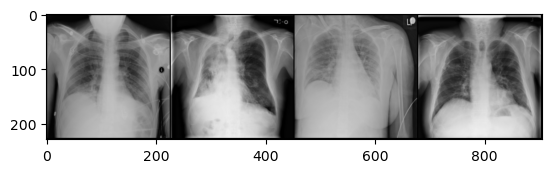

In [136]:
batch = iter(train_loader)
images, labels, _ = next(batch)

image_grid = torchvision.utils.make_grid(images[:4])
image_np = image_grid.numpy()
img = np.transpose(image_np, (1, 2, 0))
plt.imshow(img)

In [51]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [52]:
model = torchvision.models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model.fc = nn.Linear(num_ftrs, 2)

model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

C:\Users\balanton\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\balanton\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [53]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Training the model

In [54]:
num_epochs = 20
# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    # Training step
    for i, (images, labels, _) in tqdm(enumerate(train_loader)):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i + 1) % 2000 == 0:
            print("Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}"
                  .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))

    # Validation step
    correct = 0
    total = 0
    for images, labels, _ in tqdm(val_loader):
        images = images.to(device)
        labels = labels.to(device)
        predictions = model(images)
        _, predicted = torch.max(predictions, 1)
        total += labels.size(0)
        correct += (labels == predicted).sum()
    print(f'Epoch: {epoch + 1}/{num_epochs}, Val_Acc: {100 * correct / total}')

265it [09:47,  2.22s/it]
100%|██████████| 30/30 [01:05<00:00,  2.18s/it]


Epoch: 1/20, Val_Acc: 82.1684799194336


2it [00:05,  2.89s/it]

KeyboardInterrupt



## Testing the model

In [ ]:
model.eval()

correct = 0
total = 0
for images, labels, _ in tqdm(val_loader):
    images = images.to(device)
    labels = labels.to(device)
    predictions = model(images)
    _, predicted = torch.max(predictions, 1)
    total += labels.size(0)
    correct += (labels == predicted).sum()
print(f'Val_Acc: {100 * correct / total}')

## Saving the model

In [ ]:
#torch.save(model.state_dict(), 'weights/weights_only.pth')
#torch.save(model, 'model/model.pth')
#print("Model and weights saved.")

## Loading the model

In [ ]:
model = torch.load('/kaggle/input/akram-trained-model/model.pth')

In [ ]:
model.eval()

correct = 0
total = 0  
for images, labels, _ in tqdm(val_loader):
    images = images.to(device)
    labels = labels.to(device)
    predictions = model(images)
    _, predicted = torch.max(predictions, 1)
    total += labels.size(0)
    correct += (labels == predicted).sum()
print(f'Val_Acc: {100*correct/total}')

In [ ]:
def calc_iou(a, b):
    area = (b[:, 2] - b[:, 0]) * (b[:, 3] - b[:, 1])

    iw = torch.min(torch.unsqueeze(a[:, 2], dim=1), b[:, 2]) - torch.max(torch.unsqueeze(a[:, 0], 1), b[:, 0])
    ih = torch.min(torch.unsqueeze(a[:, 3], dim=1), b[:, 3]) - torch.max(torch.unsqueeze(a[:, 1], 1), b[:, 1])

    iw = torch.clamp(iw, min=0)
    ih = torch.clamp(ih, min=0)

    ua = torch.unsqueeze((a[:, 2] - a[:, 0]) * (a[:, 3] - a[:, 1]), dim=1) + area - iw * ih

    ua = torch.clamp(ua, min=1e-8)

    intersection = iw * ih

    IoU = intersection / ua

    return IoU

In [ ]:
# Load test image
label = 0
while(label==0):
    pil_img, label, box = next(image)

fig,ax = plt.subplots(1)

Orig_img_size = 1024
img_size = 224

# 'r' means relative. 'c' means center.
rx = ceil(box[0]*img_size/Orig_img_size)
ry = ceil(box[1]*img_size/Orig_img_size)
rw = ceil(box[2]*img_size/Orig_img_size)
rh = ceil(box[3]*img_size/Orig_img_size)


pil_img = np.transpose(pil_img, (1, 2, 0))
print(pil_img.shape)
rect = patches.Rectangle((rx, ry), rw, rh, linewidth=1, edgecolor='r', facecolor='none')
ax.imshow(pil_img)
ax.add_patch(rect)
print("Label : ", label, box)